In [13]:
from ParametricGraphModels.ADC_SBM import *
from config import Scenarios

### Possible Scenarios: 
- Perfect Graph: Homogenous target-distribution within clearly seperated communities and feature-clusters that overlap perfectly. Both features and communities are relevant.
- Community relevant Graph: Targets distributed homogeneously within communities in an assortative graph, where feature clusters overlap not so well. (how to adjust importance?) 
- Feature relevant Graph: analogous ...
- Random Graph: Targets are randomly distributed within a dis-assortative Graph 

**Is GAT and GRAPHSage expected to perform better in community focused graphs?** 

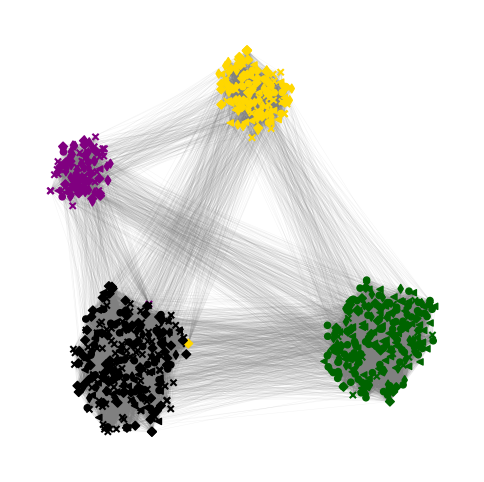

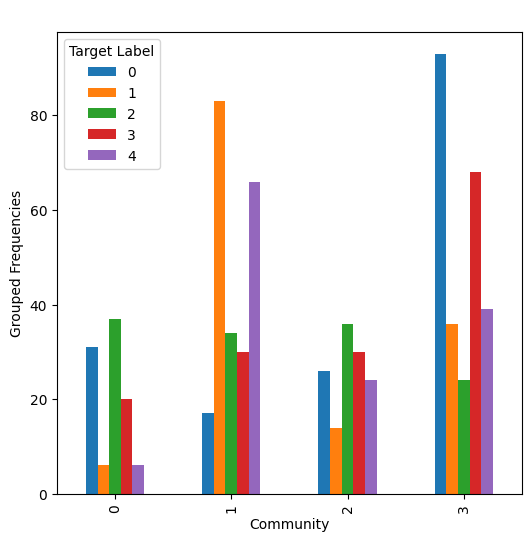

Community
0    0.719800
1    0.743100
2    0.784379
3    0.753462
dtype: float64

In [14]:
graph = from_config(Scenarios.noise)
graph.rich_plot_graph(fig_size=(6,6))
graph.purity(fig_size=(6,6), group_by="Community" ,plot_it=True)

In [3]:
# 1) ----------------- Set Params -----------------
community_sizes = [90, 140, 210, 160] # 4 communities; fixed
n = sum(community_sizes)  # number of nodes (observations)
b_communities = len(community_sizes)  # number of communities
m_features = 6  # number of numeric features; fixed
k_clusters = 6  # number of feature clusters; Overlap Scenario (over, under, match) 3,5,4
alpha, beta, lmbd = 2, 20, .5 # degree_correction params; fixed
br, wr = (.05, .1), (.4, .5) # assortative and dis-assortative

# 2) ------- Instantiate Class Object (Note: No graspy called yet!) ---------
B = getB(m=b_communities,
         b_range=br,
         w_range=wr)  # get Connection Matrix

g = ADC_SBM(community_sizes=community_sizes, B=B)  # instantiate class

# 3) ----------------- Generate the actual Graph -----------------
g.correct_degree(alpha=alpha, beta=beta, lmbd=lmbd, distribution="exp")
g.gen_graph()

# 4) ----------------- Generate Node Features -----------------
# Generate "k" centroids with "m" features
centroids = np.random.multivariate_normal(np.repeat(0, m_features),  # mu
                                     getB(m_features,
                                          (0, 0),  # Covariance
                                          (15, 20)),  # Variance (relevant for cluster separation)
                                     k_clusters)  # n
# centroids will be an array of size kxm
# if the centroid variance is low and within-variance high,
# separation becomes harder, and easier if it's the other way around !

g.set_x(n_c=k_clusters,  # number of clusters
        mu=[tuple(point) for point in centroids],  # k tuple of coordinates in m-dimensional space
        sigma=[getB(m_features, (0, 0), # Covariance
                                (.5, 1)) # Variance (relevant for cluster separation)
               for _ in range(k_clusters)],
        # similar covariance matrix for each centroid
        #w=np.random.dirichlet(np.ones(k_clusters), size=1).flatten()
        w=np.full(k_clusters, n/k_clusters, dtype=np.int64)
        )

In [4]:
ny = 5  # number of target classes; fixed
nf = m_features + 1 + b_communities # number of relevant features (community and degree considered!)

# Sensitivity plots: Community

Coefficients, that emphasize communities, will eventually bring the gini distribution of target labels between communities down to zero, meaning that communities can predict targets perfectly.

## Community Relevance

In [ ]:
ny = 5  # number of target classes; fixed
nf = m_features + 1 + b_communities # number of relevant features (community and degree considered!)

numx = 20
R = 49 # Number of Montecarlo runs 
maxx = 40 #maximum test value

xlin = np.linspace(0, maxx, num=numx)
res = np.zeros((b_communities, R, numx))
for i, v in enumerate(xlin):
    mc_res = np.zeros((b_communities, R))
    for r in range(R):
        omega = getW(ny, b_communities, m_features, w_degree=1, w_x= 0, w_com=v, exponent=1,
                     feature_info="number", k_clusters=k_clusters)
        g.set_y(task="multiclass", weights=omega, feature_info="number", eps=1)
        df = g.purity(group_by="Community", metric="gini", plot_it=False) # Feat.Cluster ; Community
        mc_res[:,r] = df.to_numpy()
        
    res[:,:,i] = mc_res
    print(i)

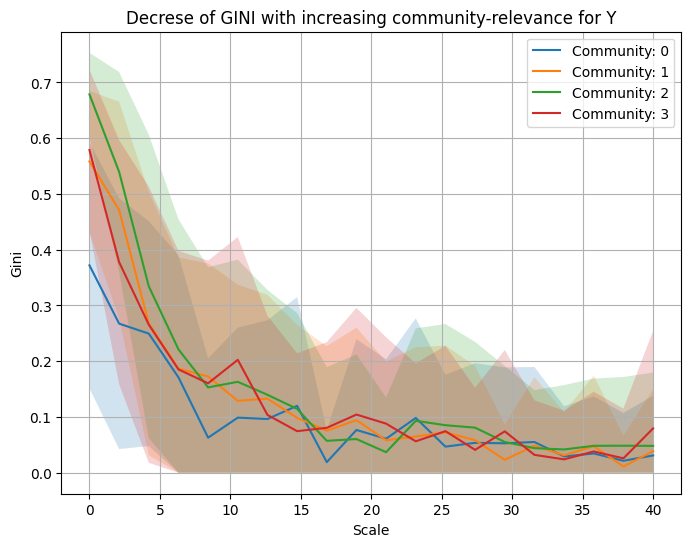

In [5]:
transposed_array = np.transpose(res, (2, 0, 1))
rowwise_averages = np.mean(transposed_array, axis=2).T
rowwise_std_devs = np.std(transposed_array, axis=2).T

plt.figure(figsize=(8, 6))
for l in range(4):
    lower_bound = np.maximum(rowwise_averages[l] - rowwise_std_devs[l], 0)
    upper_bound = rowwise_averages[l] + rowwise_std_devs[l]
 
    plt.plot(xlin, rowwise_averages[l], label=f'Community: {l}')
    plt.fill_between(xlin, lower_bound, upper_bound, alpha=0.2)

plt.xlabel('Scale')
plt.ylabel('Gini')
plt.title('Decrease of GINI with increasing community-relevance for Y')
plt.legend()
plt.grid(True)
plt.show()

## Model Error Variance 
Starting from a low purity (e.g. high influence of community), increasing the model error for the generation of Y will impurify the groups (i.e.: heterogeneous targets) 

In [ ]:
numx = 20 # number of grid values for parameter of interest 
R = 49 # Number of Montecarlo runs 
maxx = 40 #maximum test value

xlin = np.linspace(0, maxx, num=numx)
res = np.zeros((b_communities, R, numx))
for i, v in enumerate(xlin):
    mc_res = np.zeros((b_communities, R))
    for r in range(R):
        omega = getW(ny, b_communities, m_features, w_degree=1, w_x= 0, w_com=25, exponent=1,
                     feature_info="number", k_clusters=k_clusters)
        g.set_y(task="multiclass", weights=omega, feature_info="number", eps=v)
        df = g.purity(group_by="Community", metric="gini", plot_it=False) # Feat.Cluster ; Community
        mc_res[:,r] = df.to_numpy()
        
    res[:,:,i] = mc_res
    print(i)

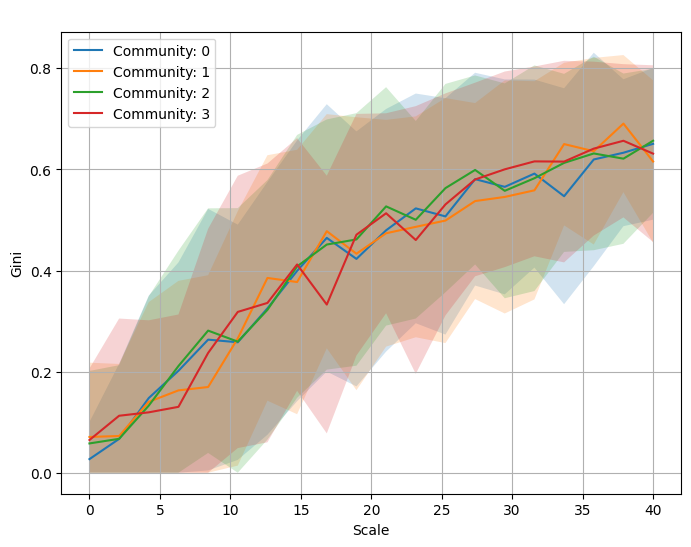

In [12]:
transposed_array = np.transpose(res, (2, 0, 1))
rowwise_averages = np.mean(transposed_array, axis=2).T
rowwise_std_devs = np.std(transposed_array, axis=2).T

plt.figure(figsize=(8, 6))
for l in range(4):
    lower_bound = np.maximum(rowwise_averages[l] - rowwise_std_devs[l], 0)
    upper_bound = rowwise_averages[l] + rowwise_std_devs[l]
 
    plt.plot(xlin, rowwise_averages[l], label=f'Community: {l}')
    plt.fill_between(xlin, lower_bound, upper_bound, alpha=0.2)

plt.xlabel('Model-error')
plt.ylabel('Gini')
plt.title('Increasing impurity with increasing model-error')
plt.legend()
plt.grid(True)
plt.show()

# Sensitivity plots: Feature Cluster 
Note: We can either emphasise the feature clusters or the communities for the generation of the targets Y.

- If the feature clusters (are well seperated and) largely determine the outcome of Y (i.e. homogenous targets within feature clusters). Graph learning will work well, regardless of how communities are connected. 
- If the communities exhibit homogenous target distributions and the graph is assortative 

In [ ]:
numx = 60
R = 49
xlin = np.linspace(0, numx, num=numx)
res = np.zeros((k_clusters, R, numx))

for i, v in enumerate(xlin):
    mc_res = np.zeros((k_clusters, R))
    for r in range(R):
        omega = getW(ny, b_communities, m_features, w_degree=1, w_x=v, w_com=0, exponent=1,
                     feature_info="cluster", k_clusters=k_clusters)
        g.set_y(task="multiclass", weights=omega, feature_info="cluster", eps=1)
        df = g.purity(group_by="Feat.Cluster", metric="gini", plot_it=False) # Feat.Cluster ; Community
        mc_res[:,r] = df.to_numpy()
    print(i)
    res[:,:,i] = mc_res

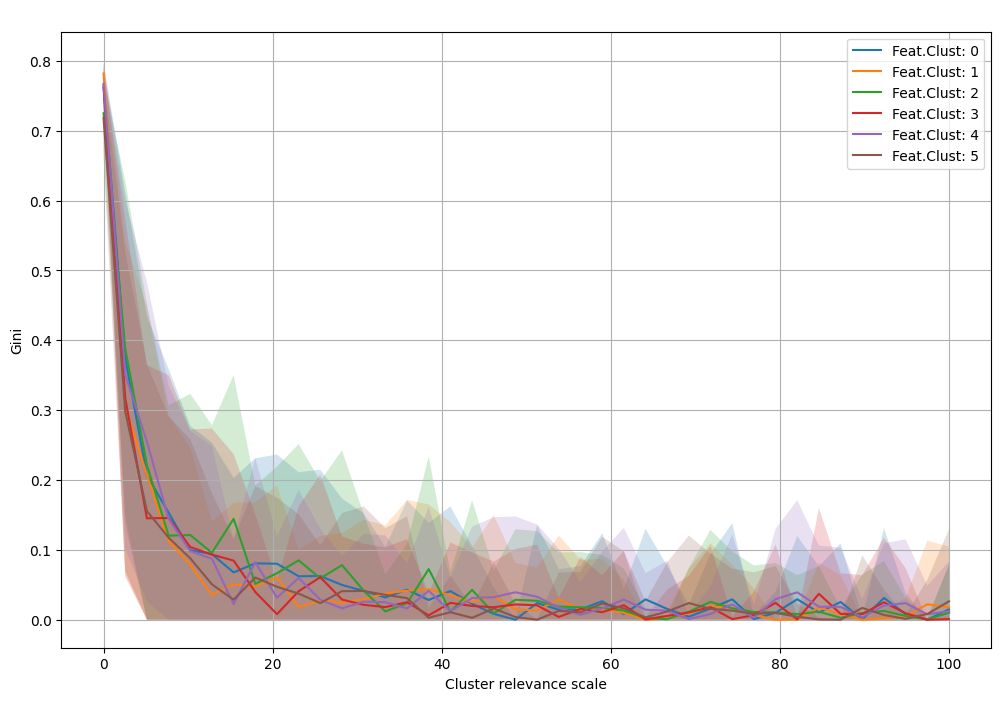

In [6]:
transposed_array = np.transpose(res, (2, 0, 1))
rowwise_averages = np.mean(transposed_array, axis=2).T
rowwise_std_devs = np.std(transposed_array, axis=2).T

plt.figure(figsize=(12, 8))
for i in range(k_clusters):
    lower_bound = np.maximum(rowwise_averages[i] - rowwise_std_devs[i], 0)
    upper_bound = rowwise_averages[i] + rowwise_std_devs[i]
 
    plt.plot(xlin, rowwise_averages[i], label=f'Feat.Clust: {i}')
    plt.fill_between(xlin, lower_bound, upper_bound, alpha=0.2)

plt.xlabel('Cluster relevance scale')
plt.ylabel('Gini')
plt.title(' ')
plt.legend()
plt.grid(True)
plt.show()

## Delta: Spectral 
- Makes no sense to use it for cluster-dummy generated y, as this will only shift the "intercept".
- deprecated  